Practical 1: The goal of this practical session is to build backprop from scratch and a small neural network (MLP).

Please return your notebook right at the end of the session.  You then have a week to return an updated version.

In [1]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from graphviz import Digraph

In [3]:
# code to display a network - do not modify this cell
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #,node_attr={'rankdir': 'TB'})
    
    layer_colors = ["#FFCCCC", "#CCFFCC", "#CCCCFF", "#FFCC99", "#99CCFF"]
    
    def get_color(node):
        if node._op == '+': return layer_colors[0]
        elif node._op == '*': return layer_colors[1]
        elif node._op == 'tanh': return layer_colors[2]
        # Ajoutez d'autres conditions ici pour d'autres opérations ou couches
        return layer_colors[-1]  # Couleur par défaut
    
    for n in nodes:
        color = get_color(n)
        dot.node(name=str(id(n)), label="{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record', style='filled', fillcolor=color)
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

In [65]:
class Value:
  
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other): # TODO: ex.1 
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    def backward():
      self.grad += out.grad
      other.grad += out.grad
    out._backward= backward
    return out

  def __mul__(self, other): # TODO: ex.1 
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data*other.data, (self, other), '*')
    def backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = backward
    return out
  
  def __pow__(self, other): # ex. 6
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')
    def backward():
      self.grad += (other * self.data**(other -1)) * out.grad
    out._backward= backward
    return out
  
  def __rmul__(self, other): # other * self
    return self * other 

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other

  def tanh(self): # TODO ex.3
    t = math.tanh(self.data)
    out = Value(t, _children=(self,), _op='tanh')
    def backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = backward
    return out
    
  def exp(self): # ex.6
    t= math.exp(self.data)
    out = Value(t, (self,), 'exp')
    def backward():
      self.grad += t*out.grad
    out._backward = backward
    return out
    
  
  def backward(self):
    
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0 #important: initialisation du gradient DL/DL=1 (le parent de tous les nodes)
    for node in reversed(topo):
      node._backward()

In [56]:
# Exercise 1: fill in __add__ and __mul__ in the Value class to enable the following function. You should get -8.0 as a result.
def lol():

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label='e'
    d = e+c; d.label='d'
    f = Value(-2.0, label='f')
    L = d*f; L.label='L'
    return L


print(lol().data)

-8.0


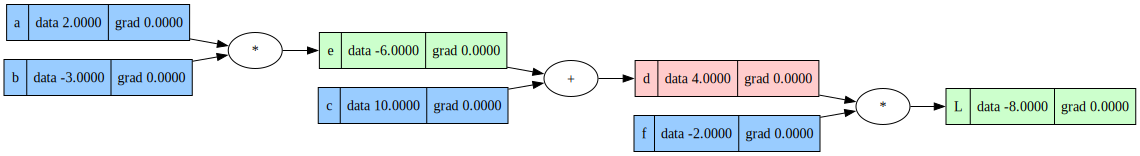

In [7]:
draw_dot(lol())

In [10]:
# Exercise 2: use the lol_grad() function below to manually compute dL/df, dL/dd, dL/de, dL/dc, dL/da, dL/db
def lol_grad():
    h = 0.0001

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label='e'
    d = e+c; d.label='d'
    f = Value(-2.0, label='f')
    L = d*f; L.label='L'
    L1 = L.data

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label='e'
    d = e+c; d.label='d'
    d += h
    f = Value(-2.0, label='f')
    L = d*f; L.label='L'
    L2 = L.data

    print((L2-L1)/h)
lol_grad()

-1.9999999999953388


In [25]:
def lol_grad():
    h = 0.0001

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label='e'
    d = e+c; d.label='d'
    f = Value(-2.0, label='f')
    L = d*f; L.label='L'
    L1 = L.data

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label='e'
    d = e+c; d.label='d'
    d += h
    f = Value(-2.0, label='f')
    L = d*f; L.label='L'
    L2 = L.data

    print((L2-L1)/h)
lol_grad() #affiche DL/dd (car h +=d pour L2 et donc on reconnaît (L1-L2)/h=(L1-L2)/d+h-d=dL/dd )

#pour dL/df:
#L=(a*b+c)*f = 4*f donc dL/df=4

#Pour dL/de:
#Avec Chaine Rule: dL/de=dL/dd*dd/de= dL/dd * d(e+c)/de = dL/dd = -2

#Pour dL/dc:
#Chaine rule aussi: DL/dc=dL/dd* dd/dc= dL/dd= -2

#Pour dL/da:
#Chaine rule: dL/da=dL/de*de/da= -2 * b = 6

-1.9999999999953388


In [ ]:
# report the values for dL/df, dL/dd, dL/de, dL/dc, dL/da, dL/db in this cell
#dL/dd = -2.0
#dL/df = 4.0
#dL/de = -2.0
#dL/dc = -2.0
#dL/da = 6.0
#dL/db = -2.0

-1.9999999999953388


In [26]:
# Exercise 3: implement the function tanh() in the Value class and build the following network
# input
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
b = Value(6.7, label='b')
x1w1 = x1*w1; x1w1.label='x1w1'
x2w2 = x2*w2; x2w2.label='x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1z2w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

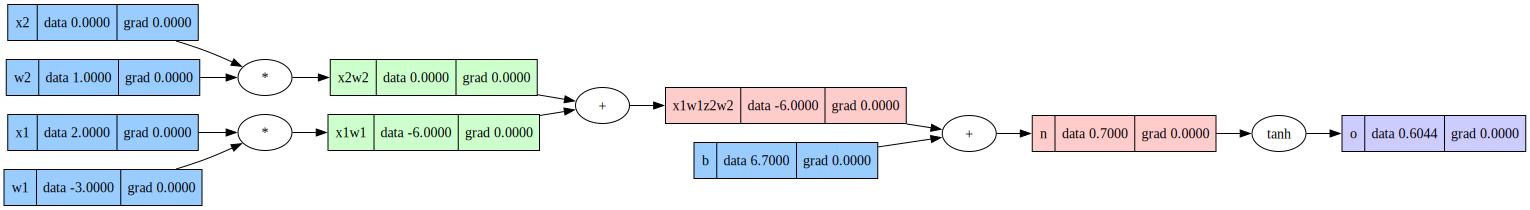

In [27]:
# o.data should be 0.6044
draw_dot(o)

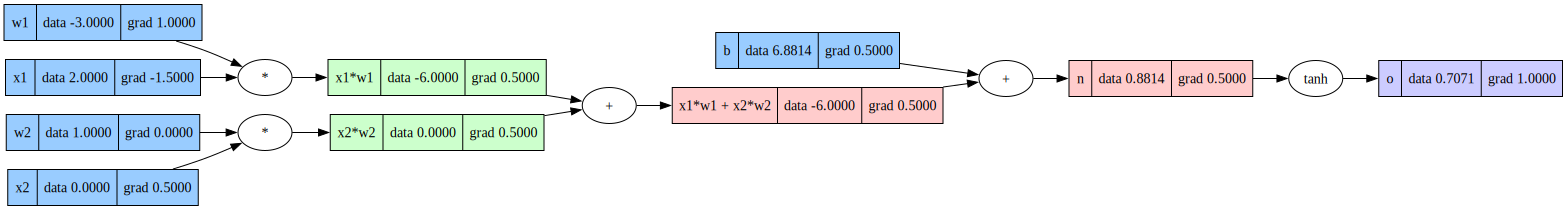

In [61]:
# Exercise 4: Implement the backward() function in each Value's operator: __add__, __mul__, __tanh__ and assign it to _backward
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# ----
#e = (2*n).exp()
#o = (e - 1) / (e + 1)
o = n.tanh()
# ----
o.label = 'o'
o.backward() #permet de faire apparaître la backward prop dans le graph (mise à jour des gradients)
draw_dot(o)

 # expected results:
 # o.data should be 0.7071
 # w1.grad = 1.0
 # w2.grad = 0.0
 # x1.grad = -1.5
 # x2.grad = 0.5

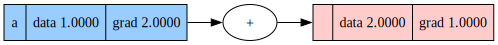

In [ ]:
# Exercise 5: why are we using self.grad += and not self.grad = in the backward() functions?  Answer as a comment in this cell. 
# Hint: create a Value "a" and then b = a + a. What happens when you do b.backward()?

 
a=Value(1.0, label="a")
c=Value(2.0, label="b")
b= a+a
b.backward()
draw_dot(b)

#We can see that the gradient is equal to the sum of the gradients of the parents of b (a and a)
#We use self.grad += because a single node can have several parents, and then we have to sum up the gradient propagation coming from each parent.

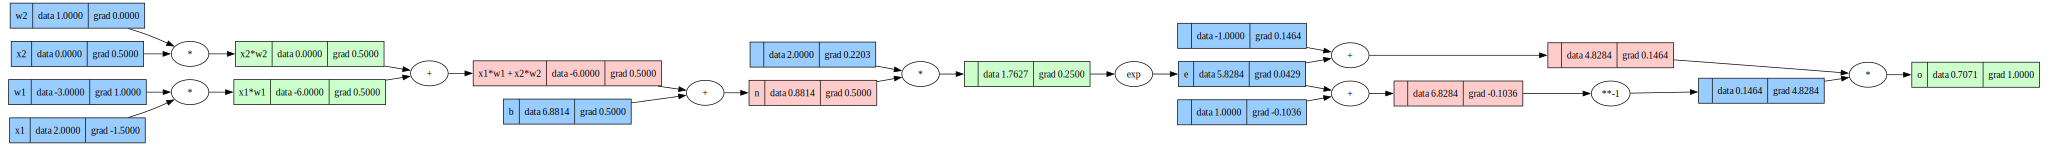

In [66]:
# Exercise 6: replace the tanh() function by a combination of exp() and division.  Implement the __exp__ and __pow__ functions in Value. You should get the same results as before.
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# ----
e = (2*n).exp(); e.label= 'e'
o = (e - 1) / (e + 1)
# ----
o.label = 'o'
o.backward()
draw_dot(o)

In [67]:
# Congratulations!  You "unlocked" the basic layer of pytorch.  Now you know what happens under the hood of the following code. Check that you get the same output as before for grad values.

import torch

x1 = torch.Tensor([2.0]).double(); x1.requires_grad = True
x2 = torch.Tensor([0.0]).double(); x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.Tensor([1.0]).double(); w2.requires_grad = True

b = torch.Tensor([6.8813735870195432]).double(); b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x1', x1.grad.item())
print('x2', x2.grad.item())
print('w1', w1.grad.item())
print('w2', w2.grad.item())


0.7071066904050358
---
x1 -1.5000003851533106
x2 0.5000001283844369
w1 1.0000002567688737
w2 0.0


In [ ]:
# Exercise 7: Let's build an MLP based on the Value class.  Fill in the Neuron, Layer and MLP classes.

In [115]:
#Note: 
#neuron: list of values
#layer: list of neurons 
#MLP: list of layers

class Neuron:
  
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))
  
  def __call__(self, x):
    # w * x + b
    act = sum([w*x for (w,x) in zip(self.w, x)])+ self.b # now : several values so: out= tan(sum(w_i*x_i) +b )
    out = act.tanh()
    return out
  
  def parameters(self):
    return self.w + [self.b]

class Layer:
  
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]
  
  def __call__(self, x):
    outs = [neuron(x) for neuron in self.neurons]  #layer: list of neuron
    return outs[0] if len(outs) == 1 else outs
  
  def parameters(self):
    return [n for neuron in self.neurons for n in neuron.parameters()] 

class MLP:
  
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x
  
  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

In [116]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x) #prediction du MLP

Value(data=-0.2734501987142668)

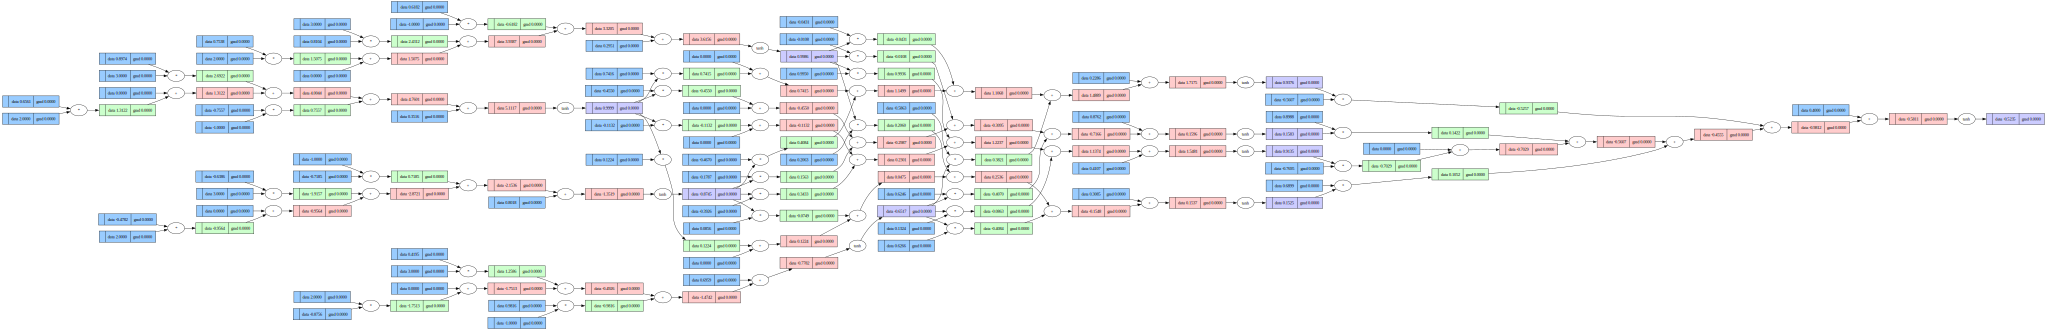

In [73]:
draw_dot(n(x))

In [117]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets


In [118]:
len(n.parameters())

41

In [119]:
ypred = [n(x) for x in xs]
ypred

[Value(data=-0.2734501987142668),
 Value(data=0.9213659500594276),
 Value(data=0.43924030319505675),
 Value(data=-0.3043154956291754)]

In [120]:
loss = sum([(a-b)**2 for (a,b) in zip(ypred, ys)])
loss

Value(data=9.085974085132552)

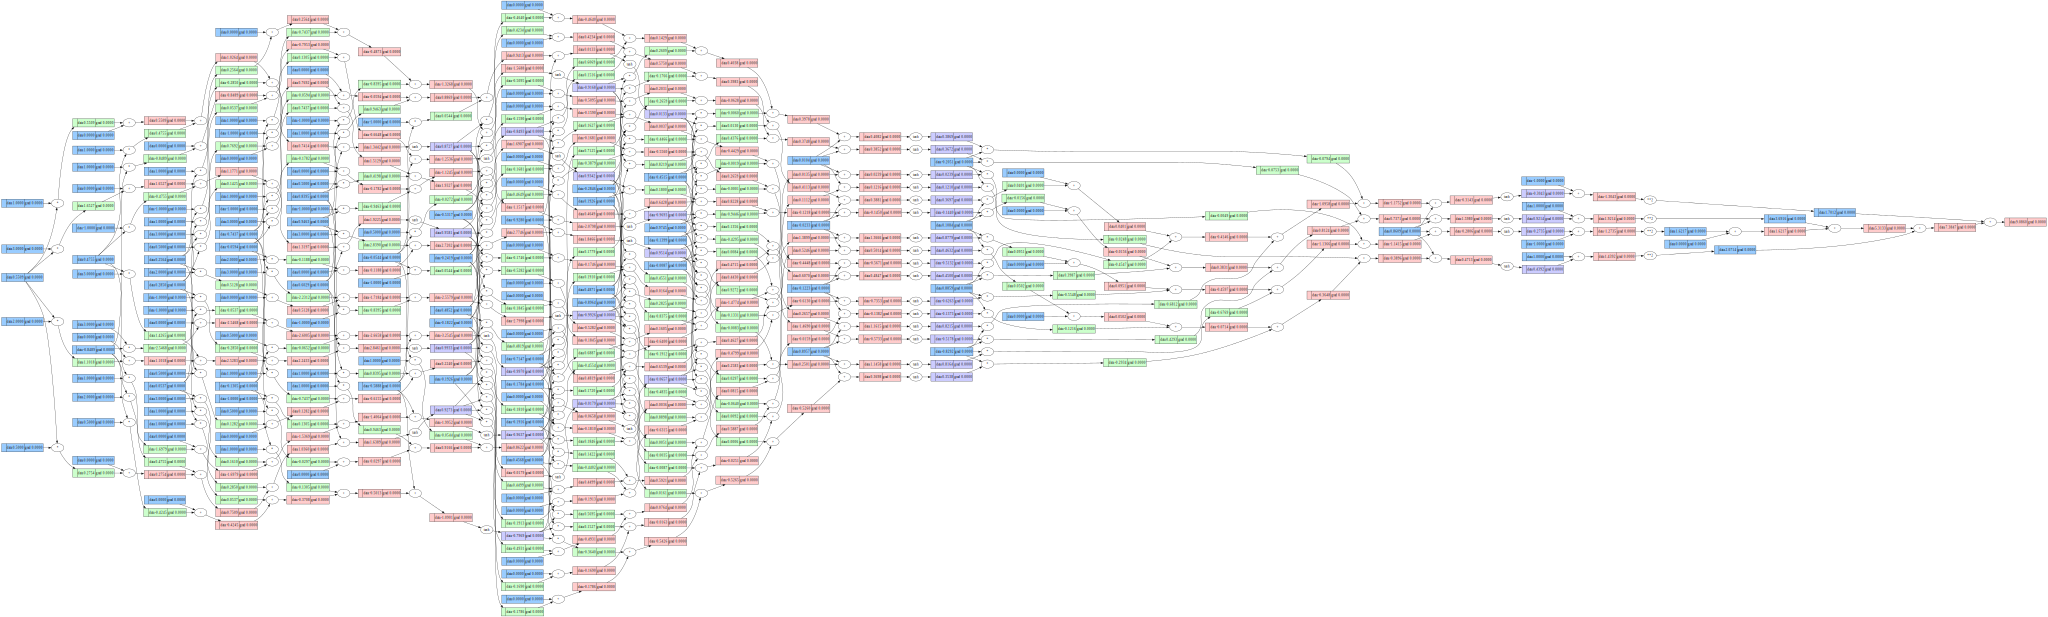

In [121]:
# see how a simple MLP can yield a complex graph already
draw_dot(loss)

In [96]:

# Exercise 8: write a training loop
for k in range(20):
    #Gradient init
    for p in n.parameters():
        p.grad=0 

    # forward pass (compute the loss)
    ypred = [n(x) for x in xs]
    loss = sum((a-b)**2 for a, b in zip(ypred, ys)) # MSE between ypred and ground-truth
    
    #backward pass 
    loss.backward()

    #Gradient descent (update of parameter w for each layer)
    lr=0.1
    for p in n.parameters():
        p.data += -lr*p.grad

    print(k, loss.data)

0 0.006068342164187257
1 0.005936246529590199
2 0.0058096505527994126
3 0.005688220981213283
4 0.005571650821365604
5 0.005459656809594015
6 0.005351977169138354
7 0.0052483696165395105
8 0.005148609585613063
9 0.005052488641805811
10 0.004959813063560001
11 0.004870402570533916
12 0.004784089181259044
13 0.004700716185135895
14 0.0046201372156495675
15 0.0045422154133781985
16 0.004466822668817429
17 0.004393838936290836
18 0.004323151611289497
19 0.004254654964512292


In [ ]:
# Exercise 9: why do you need to reset the grads to zero at every training step?  Answer as a comment in this cell.
#We need to reset the gradients at each training step so the parameter .grad does not accumulate the gradient from the previous
#iteration, which will lead to errors in the computing of the gradients. 
#Actually in the backward() function we update the gradients of each node by sum. (+=)

In [ ]:
# Exercise 10 (*): try to approximate the n^2 function with a 2-layer MLP.  why is it so hard?

xs = [[-2.0], [-1.0], [0.0], [1.0], [2.0]]
ys = [Value(x[0]**2) for x in xs]  # y = x^2

for k in range(20):
    #Gradient init
    for p in n.parameters():
        p.grad=0 

    # forward pass (compute the loss)
    ypred = [n(x) for x in xs]
    loss = sum((a-b)**2 for a, b in zip(ypred, ys)) # MSE between ypred and ground-truth
    
    #backward pass 
    loss.backward()

    #Gradient descent (update of parameter w for each layer)
    lr=0.5
    for p in n.parameters():
        p.data += -lr*p.grad

    print(k, loss.data)

#We can see that the loss does not decrease as fast as previously. 
# I assume that this is because the function is not convex and non linear so more layers are needed since the tanh fonction alone
#can be enough 

0 19.00284250772534
1 19.002754194011004
2 19.002671695222837
3 19.00259442484773
4 19.00252187512471
5 19.00245360401044
6 19.00238922468098
7 19.002328397007794
8 19.00227082058449
9 19.002216228982157
10 19.00216438498597
11 19.002115076621216
12 19.00206811381898
13 19.002023325603467
14 19.001980557707345
15 19.00193967054033
16 19.001900537450936
17 19.00186304323272
18 19.001827082835455
19 19.00179256024891
